In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 28514 
    Total predicted counts          : 28368.96
    Total off counts                : 102127.00

    Total background counts         : 20425.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 35.2 s, sys: 299 ms, total: 35.5 s
Wall time: 43.9 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 28089 
    Total predicted counts          : 28333.76
    Total off counts                : 101951.00

    Total background counts         : 20390.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 27989 
    Total predicted counts          : 28399.36
    Total off counts                : 102279.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_11 

    Total counts                    : 28154 
    Total predicted counts          : 28244.56
    Total off counts                : 101505.00

    Total background counts         : 20301.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 28124 
    Total predicted counts          : 28339.76
    Total off counts                : 101981.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_26 

    Total counts                    : 28283 
    Total predicted counts          : 28232.16
    Total off counts                : 101443.00

    Total background counts         : 20288.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_27 

    Total counts                    : 28063 
    Total predicted counts          : 28212.76
    Total off counts                : 101346.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_41 

    Total counts                    : 28243 
    Total predicted counts          : 28117.16
    Total off counts                : 100868.00

    Total background counts         : 20173.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_42 

    Total counts                    : 28201 
    Total predicted counts          : 28210.96
    Total off counts                : 101337.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_53 

    Total counts                    : 28389 
    Total predicted counts          : 28333.56
    Total off counts                : 101950.00

    Total background counts         : 20390.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_54 

    Total counts                    : 28092 
    Total predicted counts          : 28260.56
    Total off counts                : 101585.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_64 

    Total counts                    : 28153 
    Total predicted counts          : 28217.76
    Total off counts                : 101371.00

    Total background counts         : 20274.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 28131 
    Total predicted counts          : 28243.96
    Total off counts                : 101502.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_77 

    Total counts                    : 28171 
    Total predicted counts          : 28245.36
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_78 

    Total counts                    : 28261 
    Total predicted counts          : 28114.36
    Total off counts                : 100854.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_90 

    Total counts                    : 28258 
    Total predicted counts          : 28317.96
    Total off counts                : 101872.00

    Total background counts         : 20374.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_91 

    Total counts                    : 28202 
    Total predicted counts          : 28122.76
    Total off counts                : 100896.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_105 

    Total counts                    : 28304 
    Total predicted counts          : 28273.16
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_106 

    Total counts                    : 28293 
    Total predicted counts          : 28284.76
    Total off counts                : 101706.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_116 

    Total counts                    : 28364 
    Total predicted counts          : 28176.16
    Total off counts                : 101163.00

    Total background counts         : 20232.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_117 

    Total counts                    : 28060 
    Total predicted counts          : 28247.56
    Total off counts                : 101520.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_128 

    Total counts                    : 28188 
    Total predicted counts          : 28106.76
    Total off counts                : 100816.00

    Total background counts         : 20163.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_129 

    Total counts                    : 28496 
    Total predicted counts          : 28264.76
    Total off counts                : 101606.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_142 

    Total counts                    : 28408 
    Total predicted counts          : 28259.16
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_143 

    Total counts                    : 27871 
    Total predicted counts          : 28310.76
    Total off counts                : 101836.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_156 

    Total counts                    : 27976 
    Total predicted counts          : 28362.76
    Total off counts                : 102096.00

    Total background counts         : 20419.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_157 

    Total counts                    : 27952 
    Total predicted counts          : 28163.96
    Total off counts                : 101102.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_168 

    Total counts                    : 28372 
    Total predicted counts          : 28165.16
    Total off counts                : 101108.00

    Total background counts         : 20221.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_169 

    Total counts                    : 28140 
    Total predicted counts          : 28331.76
    Total off counts                : 101941.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 28333 
    Total predicted counts          : 28299.56
    Total off counts                : 101780.00

    Total background counts         : 20356.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_182 

    Total counts                    : 28447 
    Total predicted counts          : 28435.56
    Total off counts                : 102460.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_195 

    Total counts                    : 28270 
    Total predicted counts          : 28273.16
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_196 

    Total counts                    : 28190 
    Total predicted counts          : 28179.16
    Total off counts                : 101178.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_207 

    Total counts                    : 28317 
    Total predicted counts          : 28386.36
    Total off counts                : 102214.00

    Total background counts         : 20442.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_208 

    Total counts                    : 27997 
    Total predicted counts          : 28331.36
    Total off counts                : 101939.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_219 

    Total counts                    : 27994 
    Total predicted counts          : 28211.76
    Total off counts                : 101341.00

    Total background counts         : 20268.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_220 

    Total counts                    : 28343 
    Total predicted counts          : 28195.16
    Total off counts                : 101258.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_231 

    Total counts                    : 28422 
    Total predicted counts          : 28175.56
    Total off counts                : 101160.00

    Total background counts         : 20232.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_232 

    Total counts                    : 28277 
    Total predicted counts          : 28175.96
    Total off counts                : 101162.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_245 

    Total counts                    : 28421 
    Total predicted counts          : 28148.16
    Total off counts                : 101023.00

    Total background counts         : 20204.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 28397 
    Total predicted counts          : 28215.36
    Total off counts                : 101359.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_260 

    Total counts                    : 28022 
    Total predicted counts          : 28298.96
    Total off counts                : 101777.00

    Total background counts         : 20355.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_261 

    Total counts                    : 28196 
    Total predicted counts          : 28154.16
    Total off counts                : 101053.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_273 

    Total counts                    : 28175 
    Total predicted counts          : 28168.36
    Total off counts                : 101124.00

    Total background counts         : 20224.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_274 

    Total counts                    : 28000 
    Total predicted counts          : 28233.36
    Total off counts                : 101449.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_285 

    Total counts                    : 28204 
    Total predicted counts          : 28315.56
    Total off counts                : 101860.00

    Total background counts         : 20372.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_286 

    Total counts                    : 28200 
    Total predicted counts          : 28199.36
    Total off counts                : 101279.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_298 

    Total counts                    : 28250 
    Total predicted counts          : 28287.96
    Total off counts                : 101722.00

    Total background counts         : 20344.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_299 

    Total counts                    : 28198 
    Total predicted counts          : 28295.36
    Total off counts                : 101759.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_311 

    Total counts                    : 28329 
    Total predicted counts          : 28276.76
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_312 

    Total counts                    : 28067 
    Total predicted counts          : 28205.36
    Total off counts                : 101309.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 28092 
    Total predicted counts          : 28277.36
    Total off counts                : 101669.00

    Total background counts         : 20333.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_325 

    Total counts                    : 28504 
    Total predicted counts          : 28320.56
    Total off counts                : 101885.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_337 

    Total counts                    : 28332 
    Total predicted counts          : 28241.76
    Total off counts                : 101491.00

    Total background counts         : 20298.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_338 

    Total counts                    : 28064 
    Total predicted counts          : 28297.76
    Total off counts                : 101771.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_349 

    Total counts                    : 28265 
    Total predicted counts          : 28334.96
    Total off counts                : 101957.00

    Total background counts         : 20391.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_350 

    Total counts                    : 28409 
    Total predicted counts          : 28388.96
    Total off counts                : 102227.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_362 

    Total counts                    : 28471 
    Total predicted counts          : 28280.56
    Total off counts                : 101685.00

    Total background counts         : 20337.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_363 

    Total counts                    : 27998 
    Total predicted counts          : 28239.36
    Total off counts                : 101479.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_377 

    Total counts                    : 28181 
    Total predicted counts          : 28365.36
    Total off counts                : 102109.00

    Total background counts         : 20421.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_378 

    Total counts                    : 28193 
    Total predicted counts          : 28204.56
    Total off counts                : 101305.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_389 

    Total counts                    : 28059 
    Total predicted counts          : 28232.56
    Total off counts                : 101445.00

    Total background counts         : 20289.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_390 

    Total counts                    : 28229 
    Total predicted counts          : 28201.36
    Total off counts                : 101289.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_401 

    Total counts                    : 28265 
    Total predicted counts          : 28260.56
    Total off counts                : 101585.00

    Total background counts         : 20317.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_402 

    Total counts                    : 28234 
    Total predicted counts          : 28272.76
    Total off counts                : 101646.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_414 

    Total counts                    : 28239 
    Total predicted counts          : 28305.36
    Total off counts                : 101809.00

    Total background counts         : 20361.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_415 

    Total counts                    : 28110 
    Total predicted counts          : 28258.96
    Total off counts                : 101577.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_427 

    Total counts                    : 28364 
    Total predicted counts          : 28197.16
    Total off counts                : 101268.00

    Total background counts         : 20253.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_428 

    Total counts                    : 28012 
    Total predicted counts          : 28269.16
    Total off counts                : 101628.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 28261 
    Total predicted counts          : 28283.36
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_441 

    Total counts                    : 28341 
    Total predicted counts          : 28360.56
    Total off counts                : 102085.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_454 

    Total counts                    : 28337 
    Total predicted counts          : 28252.16
    Total off counts                : 101543.00

    Total background counts         : 20308.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_455 

    Total counts                    : 28164 
    Total predicted counts          : 28340.76
    Total off counts                : 101986.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_469 

    Total counts                    : 28206 
    Total predicted counts          : 28273.76
    Total off counts                : 101651.00

    Total background counts         : 20330.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_470 

    Total counts                    : 28244 
    Total predicted counts          : 28191.16
    Total off counts                : 101238.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_482 

    Total counts                    : 28178 
    Total predicted counts          : 28206.96
    Total off counts                : 101317.00

    Total background counts         : 20263.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_483 

    Total counts                    : 27860 
    Total predicted counts          : 28220.16
    Total off counts                : 101383.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 28235 
    Total predicted counts          : 28246.16
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 28280 
    Total predicted counts          : 28256.36
    Total off counts                : 101564.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_512 

    Total counts                    : 28289 
    Total predicted counts          : 28294.96
    Total off counts                : 101757.00

    Total background counts         : 20351.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_513 

    Total counts                    : 28185 
    Total predicted counts          : 28189.36
    Total off counts                : 101229.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_527 

    Total counts                    : 28321 
    Total predicted counts          : 28338.36
    Total off counts                : 101974.00

    Total background counts         : 20394.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_528 

    Total counts                    : 28164 
    Total predicted counts          : 28248.16
    Total off counts                : 101523.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_542 

    Total counts                    : 28183 
    Total predicted counts          : 28179.96
    Total off counts                : 101182.00

    Total background counts         : 20236.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_543 

    Total counts                    : 28134 
    Total predicted counts          : 28243.56
    Total off counts                : 101500.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_556 

    Total counts                    : 28178 
    Total predicted counts          : 28224.36
    Total off counts                : 101404.00

    Total background counts         : 20280.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_557 

    Total counts                    : 28362 
    Total predicted counts          : 28289.36
    Total off counts                : 101729.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 28475 
    Total predicted counts          : 28176.96
    Total off counts                : 101167.00

    Total background counts         : 20233.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_570 

    Total counts                    : 28620 
    Total predicted counts          : 28278.36
    Total off counts                : 101674.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_580 

    Total counts                    : 28162 
    Total predicted counts          : 28357.16
    Total off counts                : 102068.00

    Total background counts         : 20413.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_581 

    Total counts                    : 28233 
    Total predicted counts          : 28248.36
    Total off counts                : 101524.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_591 

    Total counts                    : 28241 
    Total predicted counts          : 28346.96
    Total off counts                : 102017.00

    Total background counts         : 20403.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_592 

    Total counts                    : 28263 
    Total predicted counts          : 28317.16
    Total off counts                : 101868.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_604 

    Total counts                    : 28024 
    Total predicted counts          : 28223.56
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_605 

    Total counts                    : 28359 
    Total predicted counts          : 28255.76
    Total off counts                : 101561.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_617 

    Total counts                    : 28365 
    Total predicted counts          : 28300.76
    Total off counts                : 101786.00

    Total background counts         : 20357.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_618 

    Total counts                    : 28353 
    Total predicted counts          : 28226.76
    Total off counts                : 101416.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_630 

    Total counts                    : 28188 
    Total predicted counts          : 28148.56
    Total off counts                : 101025.00

    Total background counts         : 20205.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_631 

    Total counts                    : 28233 
    Total predicted counts          : 28325.96
    Total off counts                : 101912.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_644 

    Total counts                    : 27998 
    Total predicted counts          : 28231.56
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 28427 
    Total predicted counts          : 28283.36
    Total off counts                : 101699.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_657 

    Total counts                    : 28107 
    Total predicted counts          : 28143.76
    Total off counts                : 101001.00

    Total background counts         : 20200.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_658 

    Total counts                    : 28462 
    Total predicted counts          : 28165.36
    Total off counts                : 101109.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_670 

    Total counts                    : 28100 
    Total predicted counts          : 28176.96
    Total off counts                : 101167.00

    Total background counts         : 20233.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_671 

    Total counts                    : 28222 
    Total predicted counts          : 28357.36
    Total off counts                : 102069.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_682 

    Total counts                    : 28288 
    Total predicted counts          : 28271.56
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_683 

    Total counts                    : 28232 
    Total predicted counts          : 28311.16
    Total off counts                : 101838.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_695 

    Total counts                    : 28571 
    Total predicted counts          : 28284.96
    Total off counts                : 101707.00

    Total background counts         : 20341.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_696 

    Total counts                    : 28201 
    Total predicted counts          : 28369.76
    Total off counts                : 102131.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_706 

    Total counts                    : 28324 
    Total predicted counts          : 28301.56
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_707 

    Total counts                    : 28182 
    Total predicted counts          : 28270.96
    Total off counts                : 101637.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_718 

    Total counts                    : 28057 
    Total predicted counts          : 28250.36
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_719 

    Total counts                    : 28535 
    Total predicted counts          : 28371.96
    Total off counts                : 102142.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_729 

    Total counts                    : 28318 
    Total predicted counts          : 28206.96
    Total off counts                : 101317.00

    Total background counts         : 20263.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_730 

    Total counts                    : 28253 
    Total predicted counts          : 28266.96
    Total off counts                : 101617.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_741 

    Total counts                    : 27958 
    Total predicted counts          : 28168.36
    Total off counts                : 101124.00

    Total background counts         : 20224.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_742 

    Total counts                    : 28217 
    Total predicted counts          : 28229.96
    Total off counts                : 101432.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_753 

    Total counts                    : 28316 
    Total predicted counts          : 28214.96
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_754 

    Total counts                    : 28217 
    Total predicted counts          : 28319.16
    Total off counts                : 101878.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_766 

    Total counts                    : 28123 
    Total predicted counts          : 28297.36
    Total off counts                : 101769.00

    Total background counts         : 20353.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_767 

    Total counts                    : 28339 
    Total predicted counts          : 28259.96
    Total off counts                : 101582.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_778 

    Total counts                    : 28130 
    Total predicted counts          : 28136.56
    Total off counts                : 100965.00

    Total background counts         : 20193.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_779 

    Total counts                    : 28440 
    Total predicted counts          : 28269.16
    Total off counts                : 101628.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_792 

    Total counts                    : 28342 
    Total predicted counts          : 28201.56
    Total off counts                : 101290.00

    Total background counts         : 20258.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_793 

    Total counts                    : 28340 
    Total predicted counts          : 28329.96
    Total off counts                : 101932.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_804 

    Total counts                    : 28302 
    Total predicted counts          : 28292.16
    Total off counts                : 101743.00

    Total background counts         : 20348.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_805 

    Total counts                    : 27967 
    Total predicted counts          : 28203.96
    Total off counts                : 101302.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_818 

    Total counts                    : 28066 
    Total predicted counts          : 28206.16
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_819 

    Total counts                    : 28272 
    Total predicted counts          : 28298.56
    Total off counts                : 101775.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_830 

    Total counts                    : 28219 
    Total predicted counts          : 28310.76
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_831 

    Total counts                    : 28217 
    Total predicted counts          : 28277.36
    Total off counts                : 101669.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_845 

    Total counts                    : 28333 
    Total predicted counts          : 28207.96
    Total off counts                : 101322.00

    Total background counts         : 20264.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_846 

    Total counts                    : 28116 
    Total predicted counts          : 28088.16
    Total off counts                : 100723.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_860 

    Total counts                    : 28243 
    Total predicted counts          : 28245.56
    Total off counts                : 101510.00

    Total background counts         : 20302.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_861 

    Total counts                    : 27782 
    Total predicted counts          : 28297.36
    Total off counts                : 101769.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_872 

    Total counts                    : 28243 
    Total predicted counts          : 28243.36
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_873 

    Total counts                    : 28001 
    Total predicted counts          : 28253.16
    Total off counts                : 101548.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_886 

    Total counts                    : 28087 
    Total predicted counts          : 28231.16
    Total off counts                : 101438.00

    Total background counts         : 20287.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_887 

    Total counts                    : 28123 
    Total predicted counts          : 28261.36
    Total off counts                : 101589.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_900 

    Total counts                    : 28249 
    Total predicted counts          : 28205.76
    Total off counts                : 101311.00

    Total background counts         : 20262.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_901 

    Total counts                    : 28290 
    Total predicted counts          : 28201.56
    Total off counts                : 101290.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_911 

    Total counts                    : 28300 
    Total predicted counts          : 28152.76
    Total off counts                : 101046.00

    Total background counts         : 20209.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_912 

    Total counts                    : 28336 
    Total predicted counts          : 28161.36
    Total off counts                : 101089.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_923 

    Total counts                    : 28140 
    Total predicted counts          : 28223.56
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_924 

    Total counts                    : 28057 
    Total predicted counts          : 28168.96
    Total off counts                : 101127.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_935 

    Total counts                    : 28228 
    Total predicted counts          : 28216.56
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_936 

    Total counts                    : 28304 
    Total predicted counts          : 28286.56
    Total off counts                : 101715.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_947 

    Total counts                    : 28150 
    Total predicted counts          : 28172.76
    Total off counts                : 101146.00

    Total background counts         : 20229.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_948 

    Total counts                    : 27994 
    Total predicted counts          : 28226.56
    Total off counts                : 101415.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_962 

    Total counts                    : 28575 
    Total predicted counts          : 28264.96
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_963 

    Total counts                    : 28305 
    Total predicted counts          : 28264.36
    Total off counts                : 101604.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_975 

    Total counts                    : 28234 
    Total predicted counts          : 28246.16
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_976 

    Total counts                    : 28604 
    Total predicted counts          : 28255.56
    Total off counts                : 101560.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_987 

    Total counts                    : 28366 
    Total predicted counts          : 28330.76
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_988 

    Total counts                    : 28152 
    Total predicted counts          : 28378.36
    Total off counts                : 102174.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_998 

    Total counts                    : 28323 
    Total predicted counts          : 28211.76
    Total off counts                : 101341.00

    Total background counts         : 20268.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_999 

    Total counts                    : 28360 
    Total predicted counts          : 28232.96
    Total off counts                : 101447.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_1012 

    Total counts                    : 28240 
    Total predicted counts          : 28216.36
    Total off counts                : 101364.00

    Total background counts         : 20272.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1013 

    Total counts                    : 28145 
    Total predicted counts          : 28204.36
    Total off counts                : 101304.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1025 

    Total counts                    : 27994 
    Total predicted counts          : 28157.96
    Total off counts                : 101072.00

    Total background counts         : 20214.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1026 

    Total counts                    : 28380 
    Total predicted counts          : 28302.76
    Total off counts                : 101796.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1037 

    Total counts                    : 28241 
    Total predicted counts          : 28111.36
    Total off counts                : 100839.00

    Total background counts         : 20167.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1038 

    Total counts                    : 28540 
    Total predicted counts          : 28241.96
    Total off counts                : 101492.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1050 

    Total counts                    : 28069 
    Total predicted counts          : 28194.56
    Total off counts                : 101255.00

    Total background counts         : 20251.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1051 

    Total counts                    : 28050 
    Total predicted counts          : 28248.96
    Total off counts                : 101527.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1063 

    Total counts                    : 28094 
    Total predicted counts          : 28304.36
    Total off counts                : 101804.00

    Total background counts         : 20360.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1064 

    Total counts                    : 28327 
    Total predicted counts          : 28262.16
    Total off counts                : 101593.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1077 

    Total counts                    : 28004 
    Total predicted counts          : 28327.36
    Total off counts                : 101919.00

    Total background counts         : 20383.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1078 

    Total counts                    : 28268 
    Total predicted counts          : 28235.16
    Total off counts                : 101458.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1090 

    Total counts                    : 28111 
    Total predicted counts          : 28122.76
    Total off counts                : 100896.00

    Total background counts         : 20179.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1091 

    Total counts                    : 27871 
    Total predicted counts          : 28354.16
    Total off counts                : 102053.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1103 

    Total counts                    : 28099 
    Total predicted counts          : 28319.56
    Total off counts                : 101880.00

    Total background counts         : 20376.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1104 

    Total counts                    : 28445 
    Total predicted counts          : 28298.96
    Total off counts                : 101777.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1116 

    Total counts                    : 28387 
    Total predicted counts          : 28210.56
    Total off counts                : 101335.00

    Total background counts         : 20267.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1117 

    Total counts                    : 28249 
    Total predicted counts          : 28266.36
    Total off counts                : 101614.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1130 

    Total counts                    : 28353 
    Total predicted counts          : 28219.76
    Total off counts                : 101381.00

    Total background counts         : 20276.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1131 

    Total counts                    : 28091 
    Total predicted counts          : 28310.76
    Total off counts                : 101836.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1143 

    Total counts                    : 28165 
    Total predicted counts          : 28264.36
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1144 

    Total counts                    : 28313 
    Total predicted counts          : 28320.16
    Total off counts                : 101883.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1157 

    Total counts                    : 28387 
    Total predicted counts          : 28329.16
    Total off counts                : 101928.00

    Total background counts         : 20385.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1158 

    Total counts                    : 28128 
    Total predicted counts          : 28174.16
    Total off counts                : 101153.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1171 

    Total counts                    : 28333 
    Total predicted counts          : 28347.56
    Total off counts                : 102020.00

    Total background counts         : 20404.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1172 

    Total counts                    : 28418 
    Total predicted counts          : 28240.16
    Total off counts                : 101483.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1183 

    Total counts                    : 28429 
    Total predicted counts          : 28300.76
    Total off counts                : 101786.00

    Total background counts         : 20357.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1184 

    Total counts                    : 28154 
    Total predicted counts          : 28252.76
    Total off counts                : 101546.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_1196 

    Total counts                    : 28380 
    Total predicted counts          : 28187.56
    Total off counts                : 101220.00

    Total background counts         : 20244.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1197 

    Total counts                    : 28486 
    Total predicted counts          : 28332.56
    Total off counts                : 101945.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1208 

    Total counts                    : 28295 
    Total predicted counts          : 28268.16
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1209 

    Total counts                    : 27985 
    Total predicted counts          : 28237.96
    Total off counts                : 101472.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1222 

    Total counts                    : 28074 
    Total predicted counts          : 28340.56
    Total off counts                : 101985.00

    Total background counts         : 20397.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1223 

    Total counts                    : 28168 
    Total predicted counts          : 28304.56
    Total off counts                : 101805.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1236 

    Total counts                    : 28201 
    Total predicted counts          : 28288.16
    Total off counts                : 101723.00

    Total background counts         : 20344.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1237 

    Total counts                    : 28443 
    Total predicted counts          : 28307.36
    Total off counts                : 101819.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1249 

    Total counts                    : 28010 
    Total predicted counts          : 28233.76
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1250 

    Total counts                    : 28167 
    Total predicted counts          : 28247.76
    Total off counts                : 101521.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1261 

    Total counts                    : 27957 
    Total predicted counts          : 28258.76
    Total off counts                : 101576.00

    Total background counts         : 20315.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1262 

    Total counts                    : 28248 
    Total predicted counts          : 28163.56
    Total off counts                : 101100.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1273 

    Total counts                    : 28310 
    Total predicted counts          : 28215.36
    Total off counts                : 101359.00

    Total background counts         : 20271.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1274 

    Total counts                    : 28308 
    Total predicted counts          : 28272.16
    Total off counts                : 101643.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1287 

    Total counts                    : 28268 
    Total predicted counts          : 28218.36
    Total off counts                : 101374.00

    Total background counts         : 20274.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1288 

    Total counts                    : 28314 
    Total predicted counts          : 28325.56
    Total off counts                : 101910.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1300 

    Total counts                    : 28469 
    Total predicted counts          : 28277.16
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1301 

    Total counts                    : 28385 
    Total predicted counts          : 28224.56
    Total off counts                : 101405.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1312 

    Total counts                    : 28261 
    Total predicted counts          : 28220.36
    Total off counts                : 101384.00

    Total background counts         : 20276.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1313 

    Total counts                    : 28100 
    Total predicted counts          : 28252.16
    Total off counts                : 101543.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1324 

    Total counts                    : 28272 
    Total predicted counts          : 28342.96
    Total off counts                : 101997.00

    Total background counts         : 20399.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1325 

    Total counts                    : 28188 
    Total predicted counts          : 28188.76
    Total off counts                : 101226.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1337 

    Total counts                    : 28272 
    Total predicted counts          : 28209.76
    Total off counts                : 101331.00

    Total background counts         : 20266.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1338 

    Total counts                    : 28119 
    Total predicted counts          : 28373.36
    Total off counts                : 102149.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1350 

    Total counts                    : 28345 
    Total predicted counts          : 28310.16
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1351 

    Total counts                    : 28243 
    Total predicted counts          : 28207.56
    Total off counts                : 101320.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1363 

    Total counts                    : 28819 
    Total predicted counts          : 28192.16
    Total off counts                : 101243.00

    Total background counts         : 20248.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1364 

    Total counts                    : 27955 
    Total predicted counts          : 28296.96
    Total off counts                : 101767.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1376 

    Total counts                    : 28423 
    Total predicted counts          : 28218.16
    Total off counts                : 101373.00

    Total background counts         : 20274.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1377 

    Total counts                    : 28479 
    Total predicted counts          : 28143.96
    Total off counts                : 101002.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1389 

    Total counts                    : 28252 
    Total predicted counts          : 28184.16
    Total off counts                : 101203.00

    Total background counts         : 20240.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1390 

    Total counts                    : 27975 
    Total predicted counts          : 28257.56
    Total off counts                : 101570.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1402 

    Total counts                    : 28265 
    Total predicted counts          : 28183.16
    Total off counts                : 101198.00

    Total background counts         : 20239.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1403 

    Total counts                    : 28396 
    Total predicted counts          : 28245.16
    Total off counts                : 101508.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1416 

    Total counts                    : 27979 
    Total predicted counts          : 28308.76
    Total off counts                : 101826.00

    Total background counts         : 20365.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1417 

    Total counts                    : 28465 
    Total predicted counts          : 28223.16
    Total off counts                : 101398.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1429 

    Total counts                    : 28212 
    Total predicted counts          : 28289.76
    Total off counts                : 101731.00

    Total background counts         : 20346.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1430 

    Total counts                    : 28110 
    Total predicted counts          : 28244.96
    Total off counts                : 101507.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1443 

    Total counts                    : 28169 
    Total predicted counts          : 28115.76
    Total off counts                : 100861.00

    Total background counts         : 20172.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1444 

    Total counts                    : 28082 
    Total predicted counts          : 28141.76
    Total off counts                : 100991.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1457 

    Total counts                    : 28255 
    Total predicted counts          : 28246.36
    Total off counts                : 101514.00

    Total background counts         : 20302.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1458 

    Total counts                    : 28342 
    Total predicted counts          : 28213.56
    Total off counts                : 101350.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1471 

    Total counts                    : 27932 
    Total predicted counts          : 28202.96
    Total off counts                : 101297.00

    Total background counts         : 20259.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1472 

    Total counts                    : 28055 
    Total predicted counts          : 28332.96
    Total off counts                : 101947.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1484 

    Total counts                    : 28199 
    Total predicted counts          : 28250.56
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1485 

    Total counts                    : 28210 
    Total predicted counts          : 28340.16
    Total off counts                : 101983.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1496 

    Total counts                    : 28152 
    Total predicted counts          : 28207.16
    Total off counts                : 101318.00

    Total background counts         : 20263.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1497 

    Total counts                    : 28231 
    Total predicted counts          : 28176.16
    Total off counts                : 101163.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1511 

    Total counts                    : 28371 
    Total predicted counts          : 28156.16
    Total off counts                : 101063.00

    Total background counts         : 20212.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1512 

    Total counts                    : 28283 
    Total predicted counts          : 28213.76
    Total off counts                : 101351.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1528 

    Total counts                    : 28219 
    Total predicted counts          : 28333.76
    Total off counts                : 101951.00

    Total background counts         : 20390.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1529 

    Total counts                    : 28280 
    Total predicted counts          : 28259.76
    Total off counts                : 101581.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1543 

    Total counts                    : 28380 
    Total predicted counts          : 28293.96
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1544 

    Total counts                    : 28099 
    Total predicted counts          : 28210.76
    Total off counts                : 101336.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1557 

    Total counts                    : 28299 
    Total predicted counts          : 28364.16
    Total off counts                : 102103.00

    Total background counts         : 20420.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1558 

    Total counts                    : 28241 
    Total predicted counts          : 28258.76
    Total off counts                : 101576.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1572 

    Total counts                    : 28400 
    Total predicted counts          : 28207.56
    Total off counts                : 101320.00

    Total background counts         : 20264.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1573 

    Total counts                    : 28120 
    Total predicted counts          : 28229.56
    Total off counts                : 101430.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1587 

    Total counts                    : 28218 
    Total predicted counts          : 28238.16
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1588 

    Total counts                    : 28188 
    Total predicted counts          : 28230.16
    Total off counts                : 101433.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1601 

    Total counts                    : 28404 
    Total predicted counts          : 28264.76
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1602 

    Total counts                    : 28118 
    Total predicted counts          : 28218.36
    Total off counts                : 101374.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1616 

    Total counts                    : 28173 
    Total predicted counts          : 28227.16
    Total off counts                : 101418.00

    Total background counts         : 20283.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1617 

    Total counts                    : 28306 
    Total predicted counts          : 28294.36
    Total off counts                : 101754.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1631 

    Total counts                    : 28076 
    Total predicted counts          : 28240.36
    Total off counts                : 101484.00

    Total background counts         : 20296.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1632 

    Total counts                    : 28066 
    Total predicted counts          : 28134.36
    Total off counts                : 100954.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1644 

    Total counts                    : 28018 
    Total predicted counts          : 28260.76
    Total off counts                : 101586.00

    Total background counts         : 20317.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1645 

    Total counts                    : 28344 
    Total predicted counts          : 28290.76
    Total off counts                : 101736.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1659 

    Total counts                    : 28217 
    Total predicted counts          : 28256.96
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1660 

    Total counts                    : 28400 
    Total predicted counts          : 28285.16
    Total off counts                : 101708.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1671 

    Total counts                    : 28112 
    Total predicted counts          : 28250.56
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1672 

    Total counts                    : 28222 
    Total predicted counts          : 28250.76
    Total off counts                : 101536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1685 

    Total counts                    : 28374 
    Total predicted counts          : 28198.36
    Total off counts                : 101274.00

    Total background counts         : 20254.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1686 

    Total counts                    : 28597 
    Total predicted counts          : 28254.76
    Total off counts                : 101556.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1698 

    Total counts                    : 28414 
    Total predicted counts          : 28212.56
    Total off counts                : 101345.00

    Total background counts         : 20269.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1699 

    Total counts                    : 28178 
    Total predicted counts          : 28141.76
    Total off counts                : 100991.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1713 

    Total counts                    : 28266 
    Total predicted counts          : 28286.56
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1714 

    Total counts                    : 28139 
    Total predicted counts          : 28227.36
    Total off counts                : 101419.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1728 

    Total counts                    : 27989 
    Total predicted counts          : 28161.36
    Total off counts                : 101089.00

    Total background counts         : 20217.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1729 

    Total counts                    : 28180 
    Total predicted counts          : 28286.16
    Total off counts                : 101713.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1743 

    Total counts                    : 28202 
    Total predicted counts          : 28208.16
    Total off counts                : 101323.00

    Total background counts         : 20264.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1744 

    Total counts                    : 28406 
    Total predicted counts          : 28275.96
    Total off counts                : 101662.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1759 

    Total counts                    : 28199 
    Total predicted counts          : 28330.56
    Total off counts                : 101935.00

    Total background counts         : 20387.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1760 

    Total counts                    : 28171 
    Total predicted counts          : 28210.16
    Total off counts                : 101333.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1775 

    Total counts                    : 28164 
    Total predicted counts          : 28112.96
    Total off counts                : 100847.00

    Total background counts         : 20169.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1776 

    Total counts                    : 27771 
    Total predicted counts          : 28294.76
    Total off counts                : 101756.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1791 

    Total counts                    : 28252 
    Total predicted counts          : 28259.76
    Total off counts                : 101581.00

    Total background counts         : 20316.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1792 

    Total counts                    : 28542 
    Total predicted counts          : 28150.76
    Total off counts                : 101036.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1808 

    Total counts                    : 28555 
    Total predicted counts          : 28188.76
    Total off counts                : 101226.00

    Total background counts         : 20245.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1809 

    Total counts                    : 28464 
    Total predicted counts          : 28084.56
    Total off counts                : 100705.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1824 

    Total counts                    : 28072 
    Total predicted counts          : 28296.76
    Total off counts                : 101766.00

    Total background counts         : 20353.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1825 

    Total counts                    : 28184 
    Total predicted counts          : 28443.16
    Total off counts                : 102498.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1839 

    Total counts                    : 28305 
    Total predicted counts          : 28161.16
    Total off counts                : 101088.00

    Total background counts         : 20217.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1840 

    Total counts                    : 27978 
    Total predicted counts          : 28250.16
    Total off counts                : 101533.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1855 

    Total counts                    : 27850 
    Total predicted counts          : 28274.16
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1856 

    Total counts                    : 28117 
    Total predicted counts          : 28342.76
    Total off counts                : 101996.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1870 

    Total counts                    : 28195 
    Total predicted counts          : 28255.16
    Total off counts                : 101558.00

    Total background counts         : 20311.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1871 

    Total counts                    : 28121 
    Total predicted counts          : 28137.56
    Total off counts                : 100970.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1886 

    Total counts                    : 28567 
    Total predicted counts          : 28153.16
    Total off counts                : 101048.00

    Total background counts         : 20209.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1887 

    Total counts                    : 28139 
    Total predicted counts          : 28223.36
    Total off counts                : 101399.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1901 

    Total counts                    : 28352 
    Total predicted counts          : 28211.36
    Total off counts                : 101339.00

    Total background counts         : 20267.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1902 

    Total counts                    : 28268 
    Total predicted counts          : 28311.96
    Total off counts                : 101842.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1913 

    Total counts                    : 28218 
    Total predicted counts          : 28311.96
    Total off counts                : 101842.00

    Total background counts         : 20368.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1914 

    Total counts                    : 28130 
    Total predicted counts          : 28223.76
    Total off counts                : 101401.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1926 

    Total counts                    : 28259 
    Total predicted counts          : 28235.56
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1927 

    Total counts                    : 28061 
    Total predicted counts          : 28312.36
    Total off counts                : 101844.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1940 

    Total counts                    : 28398 
    Total predicted counts          : 28217.16
    Total off counts                : 101368.00

    Total background counts         : 20273.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1941 

    Total counts                    : 28078 
    Total predicted counts          : 28182.16
    Total off counts                : 101193.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1954 

    Total counts                    : 28238 
    Total predicted counts          : 28179.76
    Total off counts                : 101181.00

    Total background counts         : 20236.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1955 

    Total counts                    : 28347 
    Total predicted counts          : 28214.76
    Total off counts                : 101356.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1970 

    Total counts                    : 28204 
    Total predicted counts          : 28309.96
    Total off counts                : 101832.00

    Total background counts         : 20366.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1971 

    Total counts                    : 28123 
    Total predicted counts          : 28232.96
    Total off counts                : 101447.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1986 

    Total counts                    : 28236 
    Total predicted counts          : 28297.16
    Total off counts                : 101768.00

    Total background counts         : 20353.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1987 

    Total counts                    : 28255 
    Total predicted counts          : 28254.36
    Total off counts                : 101554.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2001 

    Total counts                    : 28367 
    Total predicted counts          : 28169.16
    Total off counts                : 101128.00

    Total background counts         : 20225.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2002 

    Total counts                    : 28267 
    Total predicted counts          : 28420.76
    Total off counts                : 102386.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2015 

    Total counts                    : 28338 
    Total predicted counts          : 28334.56
    Total off counts                : 101955.00

    Total background counts         : 20391.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2016 

    Total counts                    : 28235 
    Total predicted counts          : 28320.16
    Total off counts                : 101883.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2028 

    Total counts                    : 28136 
    Total predicted counts          : 28241.76
    Total off counts                : 101491.00

    Total background counts         : 20298.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2029 

    Total counts                    : 28054 
    Total predicted counts          : 28279.56
    Total off counts                : 101680.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2042 

    Total counts                    : 28409 
    Total predicted counts          : 28341.16
    Total off counts                : 101988.00

    Total background counts         : 20397.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2043 

    Total counts                    : 28394 
    Total predicted counts          : 28172.56
    Total off counts                : 101145.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2056 

    Total counts                    : 28560 
    Total predicted counts          : 28328.76
    Total off counts                : 101926.00

    Total background counts         : 20385.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2057 

    Total counts                    : 28613 
    Total predicted counts          : 28265.16
    Total off counts                : 101608.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2067 

    Total counts                    : 28270 
    Total predicted counts          : 28225.96
    Total off counts                : 101412.00

    Total background counts         : 20282.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2068 

    Total counts                    : 28296 
    Total predicted counts          : 28141.36
    Total off counts                : 100989.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2079 

    Total counts                    : 28320 
    Total predicted counts          : 28304.76
    Total off counts                : 101806.00

    Total background counts         : 20361.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2080 

    Total counts                    : 28129 
    Total predicted counts          : 28222.36
    Total off counts                : 101394.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2092 

    Total counts                    : 28159 
    Total predicted counts          : 28268.16
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2093 

    Total counts                    : 28335 
    Total predicted counts          : 28182.36
    Total off counts                : 101194.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2105 

    Total counts                    : 28073 
    Total predicted counts          : 28342.56
    Total off counts                : 101995.00

    Total background counts         : 20399.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2106 

    Total counts                    : 28194 
    Total predicted counts          : 28129.76
    Total off counts                : 100931.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2119 

    Total counts                    : 28460 
    Total predicted counts          : 28242.16
    Total off counts                : 101493.00

    Total background counts         : 20298.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2120 

    Total counts                    : 28328 
    Total predicted counts          : 28271.56
    Total off counts                : 101640.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2132 

    Total counts                    : 28157 
    Total predicted counts          : 28222.36
    Total off counts                : 101394.00

    Total background counts         : 20278.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2133 

    Total counts                    : 27862 
    Total predicted counts          : 28186.76
    Total off counts                : 101216.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2146 

    Total counts                    : 28304 
    Total predicted counts          : 28244.16
    Total off counts                : 101503.00

    Total background counts         : 20300.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2147 

    Total counts                    : 28091 
    Total predicted counts          : 28205.96
    Total off counts                : 101312.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2161 

    Total counts                    : 28293 
    Total predicted counts          : 28363.56
    Total off counts                : 102100.00

    Total background counts         : 20420.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2162 

    Total counts                    : 28423 
    Total predicted counts          : 28281.76
    Total off counts                : 101691.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2173 

    Total counts                    : 28372 
    Total predicted counts          : 28164.76
    Total off counts                : 101106.00

    Total background counts         : 20221.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2174 

    Total counts                    : 28093 
    Total predicted counts          : 28295.56
    Total off counts                : 101760.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2187 

    Total counts                    : 28341 
    Total predicted counts          : 28305.16
    Total off counts                : 101808.00

    Total background counts         : 20361.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2188 

    Total counts                    : 28210 
    Total predicted counts          : 28206.76
    Total off counts                : 101316.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2202 

    Total counts                    : 28379 
    Total predicted counts          : 28229.16
    Total off counts                : 101428.00

    Total background counts         : 20285.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2203 

    Total counts                    : 28034 
    Total predicted counts          : 28407.36
    Total off counts                : 102319.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2215 

    Total counts                    : 28133 
    Total predicted counts          : 28214.76
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2216 

    Total counts                    : 28312 
    Total predicted counts          : 28175.36
    Total off counts                : 101159.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2230 

    Total counts                    : 28262 
    Total predicted counts          : 28303.16
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2231 

    Total counts                    : 28100 
    Total predicted counts          : 28235.16
    Total off counts                : 101458.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2244 

    Total counts                    : 28107 
    Total predicted counts          : 28229.96
    Total off counts                : 101432.00

    Total background counts         : 20286.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2245 

    Total counts                    : 28111 
    Total predicted counts          : 28152.96
    Total off counts                : 101047.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2256 

    Total counts                    : 28305 
    Total predicted counts          : 28130.76
    Total off counts                : 100936.00

    Total background counts         : 20187.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2257 

    Total counts                    : 28371 
    Total predicted counts          : 28280.56
    Total off counts                : 101685.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2268 

    Total counts                    : 27994 
    Total predicted counts          : 28261.36
    Total off counts                : 101589.00

    Total background counts         : 20317.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2269 

    Total counts                    : 28314 
    Total predicted counts          : 28329.56
    Total off counts                : 101930.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2279 

    Total counts                    : 28349 
    Total predicted counts          : 28127.56
    Total off counts                : 100920.00

    Total background counts         : 20184.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2280 

    Total counts                    : 28051 
    Total predicted counts          : 28191.96
    Total off counts                : 101242.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2292 

    Total counts                    : 28127 
    Total predicted counts          : 28203.76
    Total off counts                : 101301.00

    Total background counts         : 20260.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2293 

    Total counts                    : 28222 
    Total predicted counts          : 28348.96
    Total off counts                : 102027.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2305 

    Total counts                    : 28429 
    Total predicted counts          : 28186.56
    Total off counts                : 101215.00

    Total background counts         : 20243.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2306 

    Total counts                    : 28225 
    Total predicted counts          : 28221.76
    Total off counts                : 101391.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2319 

    Total counts                    : 28186 
    Total predicted counts          : 28327.16
    Total off counts                : 101918.00

    Total background counts         : 20383.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2320 

    Total counts                    : 28147 
    Total predicted counts          : 28135.76
    Total off counts                : 100961.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2334 

    Total counts                    : 28282 
    Total predicted counts          : 28263.76
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2335 

    Total counts                    : 28143 
    Total predicted counts          : 28230.56
    Total off counts                : 101435.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2349 

    Total counts                    : 27969 
    Total predicted counts          : 28147.16
    Total off counts                : 101018.00

    Total background counts         : 20203.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2350 

    Total counts                    : 28175 
    Total predicted counts          : 28283.76
    Total off counts                : 101701.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2362 

    Total counts                    : 28508 
    Total predicted counts          : 28305.56
    Total off counts                : 101810.00

    Total background counts         : 20362.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2363 

    Total counts                    : 28390 
    Total predicted counts          : 28319.56
    Total off counts                : 101880.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2375 

    Total counts                    : 28060 
    Total predicted counts          : 28268.76
    Total off counts                : 101626.00

    Total background counts         : 20325.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2376 

    Total counts                    : 28535 
    Total predicted counts          : 28137.96
    Total off counts                : 100972.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2388 

    Total counts                    : 28390 
    Total predicted counts          : 28332.76
    Total off counts                : 101946.00

    Total background counts         : 20389.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2389 

    Total counts                    : 28314 
    Total predicted counts          : 28188.76
    Total off counts                : 101226.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2400 

    Total counts                    : 27870 
    Total predicted counts          : 28227.56
    Total off counts                : 101420.00

    Total background counts         : 20284.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2401 

    Total counts                    : 28300 
    Total predicted counts          : 28382.76
    Total off counts                : 102196.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2414 

    Total counts                    : 28160 
    Total predicted counts          : 28286.16
    Total off counts                : 101713.00

    Total background counts         : 20342.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2415 

    Total counts                    : 28317 
    Total predicted counts          : 28112.96
    Total off counts                : 100847.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2427 

    Total counts                    : 28229 
    Total predicted counts          : 28267.56
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2428 

    Total counts                    : 28172 
    Total predicted counts          : 28357.56
    Total off counts                : 102070.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2440 

    Total counts                    : 28026 
    Total predicted counts          : 28324.36
    Total off counts                : 101904.00

    Total background counts         : 20380.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2441 

    Total counts                    : 28104 
    Total predicted counts          : 28301.56
    Total off counts                : 101790.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2454 

    Total counts                    : 28165 
    Total predicted counts          : 28262.56
    Total off counts                : 101595.00

    Total background counts         : 20319.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2455 

    Total counts                    : 28396 
    Total predicted counts          : 28192.76
    Total off counts                : 101246.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2468 

    Total counts                    : 28243 
    Total predicted counts          : 28267.96
    Total off counts                : 101622.00

    Total background counts         : 20324.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2469 

    Total counts                    : 28139 
    Total predicted counts          : 28168.96
    Total off counts                : 101127.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2484 

    Total counts                    : 28259 
    Total predicted counts          : 28198.36
    Total off counts                : 101274.00

    Total background counts         : 20254.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2485 

    Total counts                    : 27941 
    Total predicted counts          : 28321.56
    Total off counts                : 101890.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2499 

    Total counts                    : 27998 
    Total predicted counts          : 28340.56
    Total off counts                : 101985.00

    Total background counts         : 20397.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2500 

    Total counts                    : 28129 
    Total predicted counts          : 28202.96
    Total off counts                : 101297.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2513 

    Total counts                    : 28243 
    Total predicted counts          : 28330.56
    Total off counts                : 101935.00

    Total background counts         : 20387.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2514 

    Total counts                    : 28405 
    Total predicted counts          : 28250.76
    Total off counts                : 101536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2527 

    Total counts                    : 28367 
    Total predicted counts          : 28256.16
    Total off counts                : 101563.00

    Total background counts         : 20312.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2528 

    Total counts                    : 28398 
    Total predicted counts          : 28279.16
    Total off counts                : 101678.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2542 

    Total counts                    : 28358 
    Total predicted counts          : 28383.16
    Total off counts                : 102198.00

    Total background counts         : 20439.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2543 

    Total counts                    : 28202 
    Total predicted counts          : 28353.16
    Total off counts                : 102048.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2558 

    Total counts                    : 28539 
    Total predicted counts          : 28237.96
    Total off counts                : 101472.00

    Total background counts         : 20294.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2559 

    Total counts                    : 28565 
    Total predicted counts          : 28306.36
    Total off counts                : 101814.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2573 

    Total counts                    : 28256 
    Total predicted counts          : 28256.36
    Total off counts                : 101564.00

    Total background counts         : 20312.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2574 

    Total counts                    : 28057 
    Total predicted counts          : 28147.96
    Total off counts                : 101022.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2588 

    Total counts                    : 28259 
    Total predicted counts          : 28291.36
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2589 

    Total counts                    : 28374 
    Total predicted counts          : 28316.76
    Total off counts                : 101866.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2603 

    Total counts                    : 28296 
    Total predicted counts          : 28237.16
    Total off counts                : 101468.00

    Total background counts         : 20293.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2604 

    Total counts                    : 28350 
    Total predicted counts          : 28271.56
    Total off counts                : 101640.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2616 

    Total counts                    : 28502 
    Total predicted counts          : 28309.36
    Total off counts                : 101829.00

    Total background counts         : 20365.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2617 

    Total counts                    : 28601 
    Total predicted counts          : 28188.76
    Total off counts                : 101226.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2628 

    Total counts                    : 28543 
    Total predicted counts          : 28182.96
    Total off counts                : 101197.00

    Total background counts         : 20239.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2629 

    Total counts                    : 28473 
    Total predicted counts          : 28275.16
    Total off counts                : 101658.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2640 

    Total counts                    : 28252 
    Total predicted counts          : 28255.56
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2641 

    Total counts                    : 28299 
    Total predicted counts          : 28303.36
    Total off counts                : 101799.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2654 

    Total counts                    : 27944 
    Total predicted counts          : 28238.56
    Total off counts                : 101475.00

    Total background counts         : 20295.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2655 

    Total counts                    : 28202 
    Total predicted counts          : 28268.16
    Total off counts                : 101623.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2668 

    Total counts                    : 28365 
    Total predicted counts          : 28196.56
    Total off counts                : 101265.00

    Total background counts         : 20253.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2669 

    Total counts                    : 28177 
    Total predicted counts          : 28280.76
    Total off counts                : 101686.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2683 

    Total counts                    : 27950 
    Total predicted counts          : 28284.36
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2684 

    Total counts                    : 28195 
    Total predicted counts          : 28354.56
    Total off counts                : 102055.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2696 

    Total counts                    : 28069 
    Total predicted counts          : 28262.16
    Total off counts                : 101593.00

    Total background counts         : 20318.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2697 

    Total counts                    : 28459 
    Total predicted counts          : 28278.56
    Total off counts                : 101675.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2710 

    Total counts                    : 28393 
    Total predicted counts          : 28266.96
    Total off counts                : 101617.00

    Total background counts         : 20323.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2711 

    Total counts                    : 28399 
    Total predicted counts          : 28351.96
    Total off counts                : 102042.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2723 

    Total counts                    : 28327 
    Total predicted counts          : 28206.16
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2724 

    Total counts                    : 28333 
    Total predicted counts          : 28237.56
    Total off counts                : 101470.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2736 

    Total counts                    : 28226 
    Total predicted counts          : 28244.96
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2737 

    Total counts                    : 28220 
    Total predicted counts          : 28324.16
    Total off counts                : 101903.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2750 

    Total counts                    : 28247 
    Total predicted counts          : 28321.96
    Total off counts                : 101892.00

    Total background counts         : 20378.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2751 

    Total counts                    : 28337 
    Total predicted counts          : 28216.56
    Total off counts                : 101365.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2763 

    Total counts                    : 28371 
    Total predicted counts          : 28255.56
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2764 

    Total counts                    : 28264 
    Total predicted counts          : 28262.16
    Total off counts                : 101593.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2776 

    Total counts                    : 28126 
    Total predicted counts          : 28274.36
    Total off counts                : 101654.00

    Total background counts         : 20330.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2777 

    Total counts                    : 28437 
    Total predicted counts          : 28250.76
    Total off counts                : 101536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2789 

    Total counts                    : 27964 
    Total predicted counts          : 28234.76
    Total off counts                : 101456.00

    Total background counts         : 20291.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2790 

    Total counts                    : 28287 
    Total predicted counts          : 28413.16
    Total off counts                : 102348.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2802 

    Total counts                    : 28280 
    Total predicted counts          : 28346.16
    Total off counts                : 102013.00

    Total background counts         : 20402.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2803 

    Total counts                    : 28320 
    Total predicted counts          : 28195.56
    Total off counts                : 101260.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2817 

    Total counts                    : 28303 
    Total predicted counts          : 28230.36
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2818 

    Total counts                    : 28222 
    Total predicted counts          : 28346.16
    Total off counts                : 102013.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2832 

    Total counts                    : 28438 
    Total predicted counts          : 28140.96
    Total off counts                : 100987.00

    Total background counts         : 20197.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2833 

    Total counts                    : 28030 
    Total predicted counts          : 28264.56
    Total off counts                : 101605.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2846 

    Total counts                    : 28265 
    Total predicted counts          : 28287.16
    Total off counts                : 101718.00

    Total background counts         : 20343.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2847 

    Total counts                    : 28345 
    Total predicted counts          : 28238.36
    Total off counts                : 101474.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2861 

    Total counts                    : 28289 
    Total predicted counts          : 28231.76
    Total off counts                : 101441.00

    Total background counts         : 20288.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2862 

    Total counts                    : 28275 
    Total predicted counts          : 28067.36
    Total off counts                : 100619.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2876 

    Total counts                    : 28162 
    Total predicted counts          : 28194.96
    Total off counts                : 101257.00

    Total background counts         : 20251.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2877 

    Total counts                    : 28067 
    Total predicted counts          : 28282.16
    Total off counts                : 101693.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2891 

    Total counts                    : 28215 
    Total predicted counts          : 28255.56
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2892 

    Total counts                    : 28299 
    Total predicted counts          : 28112.16
    Total off counts                : 100843.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2905 

    Total counts                    : 28530 
    Total predicted counts          : 28364.96
    Total off counts                : 102107.00

    Total background counts         : 20421.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2906 

    Total counts                    : 28632 
    Total predicted counts          : 28145.56
    Total off counts                : 101010.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2918 

    Total counts                    : 28376 
    Total predicted counts          : 28214.36
    Total off counts                : 101354.00

    Total background counts         : 20270.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2919 

    Total counts                    : 28308 
    Total predicted counts          : 28241.36
    Total off counts                : 101489.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2932 

    Total counts                    : 28226 
    Total predicted counts          : 28272.56
    Total off counts                : 101645.00

    Total background counts         : 20329.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2933 

    Total counts                    : 28328 
    Total predicted counts          : 28288.56
    Total off counts                : 101725.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2948 

    Total counts                    : 28024 
    Total predicted counts          : 28352.16
    Total off counts                : 102043.00

    Total background counts         : 20408.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2949 

    Total counts                    : 28188 
    Total predicted counts          : 28200.16
    Total off counts                : 101283.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2962 

    Total counts                    : 28470 
    Total predicted counts          : 28298.36
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2963 

    Total counts                    : 28153 
    Total predicted counts          : 28201.56
    Total off counts                : 101290.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2977 

    Total counts                    : 28283 
    Total predicted counts          : 28152.96
    Total off counts                : 101047.00

    Total background counts         : 20209.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2978 

    Total counts                    : 28093 
    Total predicted counts          : 28283.76
    Total off counts                : 101701.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2992 

    Total counts                    : 28246 
    Total predicted counts          : 28187.56
    Total off counts                : 101220.00

    Total background counts         : 20244.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2993 

    Total counts                    : 28164 
    Total predicted counts          : 28304.96
    Total off counts                : 101807.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3008 

    Total counts                    : 28291 
    Total predicted counts          : 28281.16
    Total off counts                : 101688.00

    Total background counts         : 20337.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3009 

    Total counts                    : 28260 
    Total predicted counts          : 28273.36
    Total off counts                : 101649.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3023 

    Total counts                    : 28096 
    Total predicted counts          : 28210.36
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3024 

    Total counts                    : 28148 
    Total predicted counts          : 28216.56
    Total off counts                : 101365.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3036 

    Total counts                    : 28313 
    Total predicted counts          : 28256.96
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3037 

    Total counts                    : 28094 
    Total predicted counts          : 28195.36
    Total off counts                : 101259.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3049 

    Total counts                    : 28304 
    Total predicted counts          : 28273.16
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3050 

    Total counts                    : 28219 
    Total predicted counts          : 28259.36
    Total off counts                : 101579.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3063 

    Total counts                    : 28330 
    Total predicted counts          : 28365.76
    Total off counts                : 102111.00

    Total background counts         : 20422.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3064 

    Total counts                    : 28143 
    Total predicted counts          : 28286.96
    Total off counts                : 101717.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3077 

    Total counts                    : 27980 
    Total predicted counts          : 28275.76
    Total off counts                : 101661.00

    Total background counts         : 20332.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3078 

    Total counts                    : 28031 
    Total predicted counts          : 28238.76
    Total off counts                : 101476.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3091 

    Total counts                    : 27925 
    Total predicted counts          : 28261.16
    Total off counts                : 101588.00

    Total background counts         : 20317.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3092 

    Total counts                    : 28503 
    Total predicted counts          : 28380.76
    Total off counts                : 102186.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3104 

    Total counts                    : 28084 
    Total predicted counts          : 28343.36
    Total off counts                : 101999.00

    Total background counts         : 20399.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3105 

    Total counts                    : 28175 
    Total predicted counts          : 28195.96
    Total off counts                : 101262.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3118 

    Total counts                    : 27863 
    Total predicted counts          : 28281.36
    Total off counts                : 101689.00

    Total background counts         : 20337.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3119 

    Total counts                    : 28330 
    Total predicted counts          : 28195.96
    Total off counts                : 101262.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3133 

    Total counts                    : 28126 
    Total predicted counts          : 28192.76
    Total off counts                : 101246.00

    Total background counts         : 20249.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3134 

    Total counts                    : 28798 
    Total predicted counts          : 28322.96
    Total off counts                : 101897.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3148 

    Total counts                    : 28156 
    Total predicted counts          : 28191.36
    Total off counts                : 101239.00

    Total background counts         : 20247.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3149 

    Total counts                    : 28268 
    Total predicted counts          : 28217.76
    Total off counts                : 101371.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3162 

    Total counts                    : 28451 
    Total predicted counts          : 28261.96
    Total off counts                : 101592.00

    Total background counts         : 20318.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3163 

    Total counts                    : 28315 
    Total predicted counts          : 28368.36
    Total off counts                : 102124.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3176 

    Total counts                    : 28130 
    Total predicted counts          : 28356.56
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3177 

    Total counts                    : 28187 
    Total predicted counts          : 28313.16
    Total off counts                : 101848.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3188 

    Total counts                    : 28630 
    Total predicted counts          : 28307.36
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3189 

    Total counts                    : 28088 
    Total predicted counts          : 28342.76
    Total off counts                : 101996.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3201 

    Total counts                    : 28082 
    Total predicted counts          : 28221.16
    Total off counts                : 101388.00

    Total background counts         : 20277.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3202 

    Total counts                    : 28036 
    Total predicted counts          : 28250.76
    Total off counts                : 101536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3215 

    Total counts                    : 28270 
    Total predicted counts          : 28250.36
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3216 

    Total counts                    : 28510 
    Total predicted counts          : 28163.16
    Total off counts                : 101098.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3229 

    Total counts                    : 28289 
    Total predicted counts          : 28370.16
    Total off counts                : 102133.00

    Total background counts         : 20426.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3230 

    Total counts                    : 28555 
    Total predicted counts          : 28276.16
    Total off counts                : 101663.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3245 

    Total counts                    : 28072 
    Total predicted counts          : 28275.36
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3246 

    Total counts                    : 28195 
    Total predicted counts          : 28393.36
    Total off counts                : 102249.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3259 

    Total counts                    : 28327 
    Total predicted counts          : 28226.56
    Total off counts                : 101415.00

    Total background counts         : 20283.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3260 

    Total counts                    : 28242 
    Total predicted counts          : 28201.96
    Total off counts                : 101292.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3273 

    Total counts                    : 28259 
    Total predicted counts          : 28363.96
    Total off counts                : 102102.00

    Total background counts         : 20420.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3274 

    Total counts                    : 28147 
    Total predicted counts          : 28231.96
    Total off counts                : 101442.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3290 

    Total counts                    : 28435 
    Total predicted counts          : 28270.76
    Total off counts                : 101636.00

    Total background counts         : 20327.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3291 

    Total counts                    : 28727 
    Total predicted counts          : 28244.96
    Total off counts                : 101507.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3305 

    Total counts                    : 28377 
    Total predicted counts          : 28257.76
    Total off counts                : 101571.00

    Total background counts         : 20314.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3306 

    Total counts                    : 28316 
    Total predicted counts          : 28291.36
    Total off counts                : 101739.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3319 

    Total counts                    : 28233 
    Total predicted counts          : 28237.96
    Total off counts                : 101472.00

    Total background counts         : 20294.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3320 

    Total counts                    : 28366 
    Total predicted counts          : 28100.76
    Total off counts                : 100786.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3334 

    Total counts                    : 28259 
    Total predicted counts          : 28239.16
    Total off counts                : 101478.00

    Total background counts         : 20295.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3335 

    Total counts                    : 28116 
    Total predicted counts          : 28241.96
    Total off counts                : 101492.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3349 

    Total counts                    : 28265 
    Total predicted counts          : 28232.36
    Total off counts                : 101444.00

    Total background counts         : 20288.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3350 

    Total counts                    : 28310 
    Total predicted counts          : 28217.16
    Total off counts                : 101368.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3363 

    Total counts                    : 28135 
    Total predicted counts          : 28223.36
    Total off counts                : 101399.00

    Total background counts         : 20279.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3364 

    Total counts                    : 27960 
    Total predicted counts          : 28239.96
    Total off counts                : 101482.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3378 

    Total counts                    : 28259 
    Total predicted counts          : 28341.56
    Total off counts                : 101990.00

    Total background counts         : 20398.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3379 

    Total counts                    : 28184 
    Total predicted counts          : 28396.96
    Total off counts                : 102267.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3392 

    Total counts                    : 28043 
    Total predicted counts          : 28321.16
    Total off counts                : 101888.00

    Total background counts         : 20377.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3393 

    Total counts                    : 28214 
    Total predicted counts          : 28251.36
    Total off counts                : 101539.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3405 

    Total counts                    : 28361 
    Total predicted counts          : 28264.56
    Total off counts                : 101605.00

    Total background counts         : 20321.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3406 

    Total counts                    : 28171 
    Total predicted counts          : 28222.16
    Total off counts                : 101393.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3418 

    Total counts                    : 28472 
    Total predicted counts          : 28248.96
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3419 

    Total counts                    : 28417 
    Total predicted counts          : 28186.96
    Total off counts                : 101217.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3432 

    Total counts                    : 28297 
    Total predicted counts          : 28168.56
    Total off counts                : 101125.00

    Total background counts         : 20225.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3433 

    Total counts                    : 28201 
    Total predicted counts          : 28231.16
    Total off counts                : 101438.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3446 

    Total counts                    : 28280 
    Total predicted counts          : 28240.56
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3447 

    Total counts                    : 28590 
    Total predicted counts          : 28398.96
    Total off counts                : 102277.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3460 

    Total counts                    : 28263 
    Total predicted counts          : 28235.96
    Total off counts                : 101462.00

    Total background counts         : 20292.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3461 

    Total counts                    : 28304 
    Total predicted counts          : 28228.36
    Total off counts                : 101424.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3473 

    Total counts                    : 28396 
    Total predicted counts          : 28366.16
    Total off counts                : 102113.00

    Total background counts         : 20422.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3474 

    Total counts                    : 28469 
    Total predicted counts          : 28269.76
    Total off counts                : 101631.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3486 

    Total counts                    : 28252 
    Total predicted counts          : 28306.56
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3487 

    Total counts                    : 28178 
    Total predicted counts          : 28368.56
    Total off counts                : 102125.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3500 

    Total counts                    : 28414 
    Total predicted counts          : 28189.36
    Total off counts                : 101229.00

    Total background counts         : 20245.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3501 

    Total counts                    : 28099 
    Total predicted counts          : 28114.56
    Total off counts                : 100855.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3514 

    Total counts                    : 28433 
    Total predicted counts          : 28329.56
    Total off counts                : 101930.00

    Total background counts         : 20386.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3515 

    Total counts                    : 28068 
    Total predicted counts          : 28276.36
    Total off counts                : 101664.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3528 

    Total counts                    : 28080 
    Total predicted counts          : 28287.76
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3529 

    Total counts                    : 28266 
    Total predicted counts          : 28247.36
    Total off counts                : 101519.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3542 

    Total counts                    : 28224 
    Total predicted counts          : 28316.76
    Total off counts                : 101866.00

    Total background counts         : 20373.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3543 

    Total counts                    : 28349 
    Total predicted counts          : 28166.36
    Total off counts                : 101114.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3556 

    Total counts                    : 28474 
    Total predicted counts          : 28267.16
    Total off counts                : 101618.00

    Total background counts         : 20323.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3557 

    Total counts                    : 28394 
    Total predicted counts          : 28215.56
    Total off counts                : 101360.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3569 

    Total counts                    : 28253 
    Total predicted counts          : 28257.36
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3570 

    Total counts                    : 28499 
    Total predicted counts          : 28210.76
    Total off counts                : 101336.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3582 

    Total counts                    : 28201 
    Total predicted counts          : 28334.96
    Total off counts                : 101957.00

    Total background counts         : 20391.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3583 

    Total counts                    : 28184 
    Total predicted counts          : 28302.36
    Total off counts                : 101794.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3598 

    Total counts                    : 28012 
    Total predicted counts          : 28312.16
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3599 

    Total counts                    : 28187 
    Total predicted counts          : 28159.56
    Total off counts                : 101080.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3613 

    Total counts                    : 28306 
    Total predicted counts          : 28313.96
    Total off counts                : 101852.00

    Total background counts         : 20370.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3614 

    Total counts                    : 28354 
    Total predicted counts          : 28290.36
    Total off counts                : 101734.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3628 

    Total counts                    : 28335 
    Total predicted counts          : 28136.96
    Total off counts                : 100967.00

    Total background counts         : 20193.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3629 

    Total counts                    : 28507 
    Total predicted counts          : 28311.96
    Total off counts                : 101842.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3643 

    Total counts                    : 28231 
    Total predicted counts          : 28372.96
    Total off counts                : 102147.00

    Total background counts         : 20429.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3644 

    Total counts                    : 28400 
    Total predicted counts          : 28292.76
    Total off counts                : 101746.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3659 

    Total counts                    : 28324 
    Total predicted counts          : 28281.56
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3660 

    Total counts                    : 28061 
    Total predicted counts          : 28247.56
    Total off counts                : 101520.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3675 

    Total counts                    : 28440 
    Total predicted counts          : 28298.56
    Total off counts                : 101775.00

    Total background counts         : 20355.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3676 

    Total counts                    : 28134 
    Total predicted counts          : 28285.16
    Total off counts                : 101708.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3690 

    Total counts                    : 28314 
    Total predicted counts          : 28249.16
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3691 

    Total counts                    : 28348 
    Total predicted counts          : 28155.16
    Total off counts                : 101058.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3705 

    Total counts                    : 28058 
    Total predicted counts          : 28301.36
    Total off counts                : 101789.00

    Total background counts         : 20357.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3706 

    Total counts                    : 28287 
    Total predicted counts          : 28238.16
    Total off counts                : 101473.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3719 

    Total counts                    : 28260 
    Total predicted counts          : 28355.76
    Total off counts                : 102061.00

    Total background counts         : 20412.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3720 

    Total counts                    : 28109 
    Total predicted counts          : 28138.16
    Total off counts                : 100973.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3732 

    Total counts                    : 28423 
    Total predicted counts          : 28181.76
    Total off counts                : 101191.00

    Total background counts         : 20238.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3733 

    Total counts                    : 28509 
    Total predicted counts          : 28321.76
    Total off counts                : 101891.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3745 

    Total counts                    : 28180 
    Total predicted counts          : 28227.56
    Total off counts                : 101420.00

    Total background counts         : 20284.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3746 

    Total counts                    : 28309 
    Total predicted counts          : 28295.56
    Total off counts                : 101760.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3759 

    Total counts                    : 28047 
    Total predicted counts          : 28246.16
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3760 

    Total counts                    : 28337 
    Total predicted counts          : 28170.96
    Total off counts                : 101137.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3774 

    Total counts                    : 28037 
    Total predicted counts          : 28359.36
    Total off counts                : 102079.00

    Total background counts         : 20415.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3775 

    Total counts                    : 27944 
    Total predicted counts          : 28257.96
    Total off counts                : 101572.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3790 

    Total counts                    : 28168 
    Total predicted counts          : 28203.96
    Total off counts                : 101302.00

    Total background counts         : 20260.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3791 

    Total counts                    : 28394 
    Total predicted counts          : 28272.76
    Total off counts                : 101646.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3806 

    Total counts                    : 28319 
    Total predicted counts          : 28317.76
    Total off counts                : 101871.00

    Total background counts         : 20374.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3807 

    Total counts                    : 28683 
    Total predicted counts          : 28302.36
    Total off counts                : 101794.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3821 

    Total counts                    : 27892 
    Total predicted counts          : 28205.56
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3822 

    Total counts                    : 28198 
    Total predicted counts          : 28262.76
    Total off counts                : 101596.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3836 

    Total counts                    : 28092 
    Total predicted counts          : 28345.36
    Total off counts                : 102009.00

    Total background counts         : 20401.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3837 

    Total counts                    : 28335 
    Total predicted counts          : 28218.36
    Total off counts                : 101374.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3851 

    Total counts                    : 28036 
    Total predicted counts          : 28279.76
    Total off counts                : 101681.00

    Total background counts         : 20336.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3852 

    Total counts                    : 28180 
    Total predicted counts          : 28300.16
    Total off counts                : 101783.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3864 

    Total counts                    : 28122 
    Total predicted counts          : 28206.96
    Total off counts                : 101317.00

    Total background counts         : 20263.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3865 

    Total counts                    : 28477 
    Total predicted counts          : 28398.76
    Total off counts                : 102276.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3878 

    Total counts                    : 28267 
    Total predicted counts          : 28281.36
    Total off counts                : 101689.00

    Total background counts         : 20337.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3879 

    Total counts                    : 28196 
    Total predicted counts          : 28204.56
    Total off counts                : 101305.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3890 

    Total counts                    : 28320 
    Total predicted counts          : 28099.36
    Total off counts                : 100779.00

    Total background counts         : 20155.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3891 

    Total counts                    : 28237 
    Total predicted counts          : 28146.16
    Total off counts                : 101013.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3902 

    Total counts                    : 27894 
    Total predicted counts          : 28293.56
    Total off counts                : 101750.00

    Total background counts         : 20350.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3903 

    Total counts                    : 28289 
    Total predicted counts          : 28228.76
    Total off counts                : 101426.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3914 

    Total counts                    : 28090 
    Total predicted counts          : 28338.16
    Total off counts                : 101973.00

    Total background counts         : 20394.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3915 

    Total counts                    : 27998 
    Total predicted counts          : 28172.76
    Total off counts                : 101146.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3927 

    Total counts                    : 28369 
    Total predicted counts          : 28351.36
    Total off counts                : 102039.00

    Total background counts         : 20407.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3928 

    Total counts                    : 27851 
    Total predicted counts          : 28217.76
    Total off counts                : 101371.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3938 

    Total counts                    : 28124 
    Total predicted counts          : 28317.36
    Total off counts                : 101869.00

    Total background counts         : 20373.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3939 

    Total counts                    : 28325 
    Total predicted counts          : 28206.36
    Total off counts                : 101314.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3950 

    Total counts                    : 28520 
    Total predicted counts          : 28246.16
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3951 

    Total counts                    : 28098 
    Total predicted counts          : 28280.96
    Total off counts                : 101687.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3964 

    Total counts                    : 28283 
    Total predicted counts          : 28364.76
    Total off counts                : 102106.00

    Total background counts         : 20421.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3965 

    Total counts                    : 28564 
    Total predicted counts          : 28139.16
    Total off counts                : 100978.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3977 

    Total counts                    : 28337 
    Total predicted counts          : 28140.76
    Total off counts                : 100986.00

    Total background counts         : 20197.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3978 

    Total counts                    : 27952 
    Total predicted counts          : 28225.16
    Total off counts                : 101408.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3991 

    Total counts                    : 28033 
    Total predicted counts          : 28269.76
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3992 

    Total counts                    : 28489 
    Total predicted counts          : 28415.16
    Total off counts                : 102358.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4002 

    Total counts                    : 28129 
    Total predicted counts          : 28190.76
    Total off counts                : 101236.00

    Total background counts         : 20247.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4003 

    Total counts                    : 28158 
    Total predicted counts          : 28339.96
    Total off counts                : 101982.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4014 

    Total counts                    : 27882 
    Total predicted counts          : 28157.76
    Total off counts                : 101071.00

    Total background counts         : 20214.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4015 

    Total counts                    : 28354 
    Total predicted counts          : 28230.76
    Total off counts                : 101436.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4026 

    Total counts                    : 28011 
    Total predicted counts          : 28280.16
    Total off counts                : 101683.00

    Total background counts         : 20336.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4027 

    Total counts                    : 27842 
    Total predicted counts          : 28245.36
    Total off counts                : 101509.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4039 

    Total counts                    : 28043 
    Total predicted counts          : 28335.56
    Total off counts                : 101960.00

    Total background counts         : 20392.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4040 

    Total counts                    : 28153 
    Total predicted counts          : 28192.36
    Total off counts                : 101244.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4054 

    Total counts                    : 28317 
    Total predicted counts          : 28294.36
    Total off counts                : 101754.00

    Total background counts         : 20350.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4055 

    Total counts                    : 28319 
    Total predicted counts          : 28206.36
    Total off counts                : 101314.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4069 

    Total counts                    : 28372 
    Total predicted counts          : 28171.96
    Total off counts                : 101142.00

    Total background counts         : 20228.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4070 

    Total counts                    : 28446 
    Total predicted counts          : 28260.76
    Total off counts                : 101586.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4083 

    Total counts                    : 28457 
    Total predicted counts          : 28148.76
    Total off counts                : 101026.00

    Total background counts         : 20205.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4084 

    Total counts                    : 28312 
    Total predicted counts          : 28190.36
    Total off counts                : 101234.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4099 

    Total counts                    : 28257 
    Total predicted counts          : 28229.76
    Total off counts                : 101431.00

    Total background counts         : 20286.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4100 

    Total counts                    : 28475 
    Total predicted counts          : 28240.36
    Total off counts                : 101484.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4114 

    Total counts                    : 28327 
    Total predicted counts          : 28260.96
    Total off counts                : 101587.00

    Total background counts         : 20317.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4115 

    Total counts                    : 28423 
    Total predicted counts          : 28212.36
    Total off counts                : 101344.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4127 

    Total counts                    : 28321 
    Total predicted counts          : 28246.36
    Total off counts                : 101514.00

    Total background counts         : 20302.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4128 

    Total counts                    : 28288 
    Total predicted counts          : 28306.56
    Total off counts                : 101815.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4142 

    Total counts                    : 28412 
    Total predicted counts          : 28208.16
    Total off counts                : 101323.00

    Total background counts         : 20264.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4143 

    Total counts                    : 28253 
    Total predicted counts          : 28293.96
    Total off counts                : 101752.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4158 

    Total counts                    : 28029 
    Total predicted counts          : 28244.56
    Total off counts                : 101505.00

    Total background counts         : 20301.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4159 

    Total counts                    : 28276 
    Total predicted counts          : 28293.76
    Total off counts                : 101751.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4173 

    Total counts                    : 28164 
    Total predicted counts          : 28192.16
    Total off counts                : 101243.00

    Total background counts         : 20248.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4174 

    Total counts                    : 28316 
    Total predicted counts          : 28275.56
    Total off counts                : 101660.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4187 

    Total counts                    : 28560 
    Total predicted counts          : 28205.76
    Total off counts                : 101311.00

    Total background counts         : 20262.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4188 

    Total counts                    : 27955 
    Total predicted counts          : 28293.76
    Total off counts                : 101751.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4201 

    Total counts                    : 28170 
    Total predicted counts          : 28272.76
    Total off counts                : 101646.00

    Total background counts         : 20329.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4202 

    Total counts                    : 28186 
    Total predicted counts          : 28142.96
    Total off counts                : 100997.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4213 

    Total counts                    : 28171 
    Total predicted counts          : 28178.16
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4214 

    Total counts                    : 28516 
    Total predicted counts          : 28221.76
    Total off counts                : 101391.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4228 

    Total counts                    : 28387 
    Total predicted counts          : 28128.16
    Total off counts                : 100923.00

    Total background counts         : 20184.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4229 

    Total counts                    : 28389 
    Total predicted counts          : 28304.76
    Total off counts                : 101806.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4241 

    Total counts                    : 28354 
    Total predicted counts          : 28167.96
    Total off counts                : 101122.00

    Total background counts         : 20224.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4242 

    Total counts                    : 28450 
    Total predicted counts          : 28321.16
    Total off counts                : 101888.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4256 

    Total counts                    : 28263 
    Total predicted counts          : 28267.76
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4257 

    Total counts                    : 28116 
    Total predicted counts          : 28346.36
    Total off counts                : 102014.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4273 

    Total counts                    : 28266 
    Total predicted counts          : 28205.56
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4274 

    Total counts                    : 28219 
    Total predicted counts          : 28294.96
    Total off counts                : 101757.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4288 

    Total counts                    : 28269 
    Total predicted counts          : 28216.76
    Total off counts                : 101366.00

    Total background counts         : 20273.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4289 

    Total counts                    : 28238 
    Total predicted counts          : 28278.96
    Total off counts                : 101677.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4303 

    Total counts                    : 28138 
    Total predicted counts          : 28321.96
    Total off counts                : 101892.00

    Total background counts         : 20378.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4304 

    Total counts                    : 28006 
    Total predicted counts          : 28197.76
    Total off counts                : 101271.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4320 

    Total counts                    : 28334 
    Total predicted counts          : 28207.76
    Total off counts                : 101321.00

    Total background counts         : 20264.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4321 

    Total counts                    : 28104 
    Total predicted counts          : 28284.16
    Total off counts                : 101703.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4336 

    Total counts                    : 28281 
    Total predicted counts          : 28149.16
    Total off counts                : 101028.00

    Total background counts         : 20205.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4337 

    Total counts                    : 28065 
    Total predicted counts          : 28257.36
    Total off counts                : 101569.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4352 

    Total counts                    : 28612 
    Total predicted counts          : 28262.16
    Total off counts                : 101593.00

    Total background counts         : 20318.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4353 

    Total counts                    : 28438 
    Total predicted counts          : 28246.56
    Total off counts                : 101515.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4368 

    Total counts                    : 28256 
    Total predicted counts          : 28255.56
    Total off counts                : 101560.00

    Total background counts         : 20312.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4369 

    Total counts                    : 28224 
    Total predicted counts          : 28197.36
    Total off counts                : 101269.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4384 

    Total counts                    : 28285 
    Total predicted counts          : 28147.36
    Total off counts                : 101019.00

    Total background counts         : 20203.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4385 

    Total counts                    : 28218 
    Total predicted counts          : 28367.16
    Total off counts                : 102118.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4402 

    Total counts                    : 28427 
    Total predicted counts          : 28228.36
    Total off counts                : 101424.00

    Total background counts         : 20284.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4403 

    Total counts                    : 28116 
    Total predicted counts          : 28164.76
    Total off counts                : 101106.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4421 

    Total counts                    : 28218 
    Total predicted counts          : 28364.16
    Total off counts                : 102103.00

    Total background counts         : 20420.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4422 

    Total counts                    : 28304 
    Total predicted counts          : 28200.16
    Total off counts                : 101283.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4440 

    Total counts                    : 28386 
    Total predicted counts          : 28296.36
    Total off counts                : 101764.00

    Total background counts         : 20352.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4441 

    Total counts                    : 28167 
    Total predicted counts          : 28207.96
    Total off counts                : 101322.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4456 

    Total counts                    : 27998 
    Total predicted counts          : 28260.96
    Total off counts                : 101587.00

    Total background counts         : 20317.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4457 

    Total counts                    : 28189 
    Total predicted counts          : 28279.56
    Total off counts                : 101680.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4474 

    Total counts                    : 28217 
    Total predicted counts          : 28268.56
    Total off counts                : 101625.00

    Total background counts         : 20325.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4475 

    Total counts                    : 28442 
    Total predicted counts          : 28143.16
    Total off counts                : 100998.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4491 

    Total counts                    : 28441 
    Total predicted counts          : 28253.76
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4492 

    Total counts                    : 28300 
    Total predicted counts          : 28137.96
    Total off counts                : 100972.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4508 

    Total counts                    : 28437 
    Total predicted counts          : 28234.96
    Total off counts                : 101457.00

    Total background counts         : 20291.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4509 

    Total counts                    : 28382 
    Total predicted counts          : 28242.16
    Total off counts                : 101493.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4525 

    Total counts                    : 28407 
    Total predicted counts          : 28292.36
    Total off counts                : 101744.00

    Total background counts         : 20348.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4526 

    Total counts                    : 28523 
    Total predicted counts          : 28186.56
    Total off counts                : 101215.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4542 

    Total counts                    : 28375 
    Total predicted counts          : 28176.76
    Total off counts                : 101166.00

    Total background counts         : 20233.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4543 

    Total counts                    : 27954 
    Total predicted counts          : 28281.36
    Total off counts                : 101689.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4559 

    Total counts                    : 28399 
    Total predicted counts          : 28259.36
    Total off counts                : 101579.00

    Total background counts         : 20315.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4560 

    Total counts                    : 28268 
    Total predicted counts          : 28204.96
    Total off counts                : 101307.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4575 

    Total counts                    : 28143 
    Total predicted counts          : 28296.16
    Total off counts                : 101763.00

    Total background counts         : 20352.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4576 

    Total counts                    : 28221 
    Total predicted counts          : 28188.56
    Total off counts                : 101225.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4589 

    Total counts                    : 28300 
    Total predicted counts          : 28228.16
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4590 

    Total counts                    : 28357 
    Total predicted counts          : 28306.16
    Total off counts                : 101813.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4604 

    Total counts                    : 28105 
    Total predicted counts          : 28397.16
    Total off counts                : 102268.00

    Total background counts         : 20453.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4605 

    Total counts                    : 28142 
    Total predicted counts          : 28267.16
    Total off counts                : 101618.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4619 

    Total counts                    : 28147 
    Total predicted counts          : 28276.76
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4620 

    Total counts                    : 28159 
    Total predicted counts          : 28260.96
    Total off counts                : 101587.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4631 

    Total counts                    : 28175 
    Total predicted counts          : 28228.36
    Total off counts                : 101424.00

    Total background counts         : 20284.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4632 

    Total counts                    : 28223 
    Total predicted counts          : 28329.96
    Total off counts                : 101932.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4649 

    Total counts                    : 28347 
    Total predicted counts          : 28245.96
    Total off counts                : 101512.00

    Total background counts         : 20302.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4650 

    Total counts                    : 28522 
    Total predicted counts          : 28353.56
    Total off counts                : 102050.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4666 

    Total counts                    : 28369 
    Total predicted counts          : 28241.36
    Total off counts                : 101489.00

    Total background counts         : 20297.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4667 

    Total counts                    : 28098 
    Total predicted counts          : 28335.16
    Total off counts                : 101958.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4682 

    Total counts                    : 28322 
    Total predicted counts          : 28250.16
    Total off counts                : 101533.00

    Total background counts         : 20306.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4683 

    Total counts                    : 28409 
    Total predicted counts          : 28318.76
    Total off counts                : 101876.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4696 

    Total counts                    : 27999 
    Total predicted counts          : 28237.56
    Total off counts                : 101470.00

    Total background counts         : 20294.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4697 

    Total counts                    : 28054 
    Total predicted counts          : 28229.36
    Total off counts                : 101429.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4712 

    Total counts                    : 28170 
    Total predicted counts          : 28291.36
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4713 

    Total counts                    : 28274 
    Total predicted counts          : 28349.16
    Total off counts                : 102028.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4728 

    Total counts                    : 28158 
    Total predicted counts          : 28226.96
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4729 

    Total counts                    : 28291 
    Total predicted counts          : 28392.76
    Total off counts                : 102246.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4743 

    Total counts                    : 28321 
    Total predicted counts          : 28264.56
    Total off counts                : 101605.00

    Total background counts         : 20321.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4744 

    Total counts                    : 28379 
    Total predicted counts          : 28281.96
    Total off counts                : 101692.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4758 

    Total counts                    : 28275 
    Total predicted counts          : 28329.16
    Total off counts                : 101928.00

    Total background counts         : 20385.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4759 

    Total counts                    : 28220 
    Total predicted counts          : 28294.56
    Total off counts                : 101755.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4774 

    Total counts                    : 28177 
    Total predicted counts          : 28384.76
    Total off counts                : 102206.00

    Total background counts         : 20441.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4775 

    Total counts                    : 28253 
    Total predicted counts          : 28227.36
    Total off counts                : 101419.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4788 

    Total counts                    : 28217 
    Total predicted counts          : 28259.36
    Total off counts                : 101579.00

    Total background counts         : 20315.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4789 

    Total counts                    : 28283 
    Total predicted counts          : 28257.16
    Total off counts                : 101568.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4803 

    Total counts                    : 28147 
    Total predicted counts          : 28186.96
    Total off counts                : 101217.00

    Total background counts         : 20243.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4804 

    Total counts                    : 28306 
    Total predicted counts          : 28208.36
    Total off counts                : 101324.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4829 

    Total counts                    : 28438 
    Total predicted counts          : 28231.36
    Total off counts                : 101439.00

    Total background counts         : 20287.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4830 

    Total counts                    : 28272 
    Total predicted counts          : 28191.76
    Total off counts                : 101241.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4844 

    Total counts                    : 28133 
    Total predicted counts          : 28232.76
    Total off counts                : 101446.00

    Total background counts         : 20289.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4845 

    Total counts                    : 28272 
    Total predicted counts          : 28320.16
    Total off counts                : 101883.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4858 

    Total counts                    : 28303 
    Total predicted counts          : 28263.16
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4859 

    Total counts                    : 28154 
    Total predicted counts          : 28218.96
    Total off counts                : 101377.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4874 

    Total counts                    : 28355 
    Total predicted counts          : 28421.76
    Total off counts                : 102391.00

    Total background counts         : 20478.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4875 

    Total counts                    : 28254 
    Total predicted counts          : 28312.76
    Total off counts                : 101846.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4890 

    Total counts                    : 28117 
    Total predicted counts          : 28221.96
    Total off counts                : 101392.00

    Total background counts         : 20278.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4891 

    Total counts                    : 28099 
    Total predicted counts          : 28256.96
    Total off counts                : 101567.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4905 

    Total counts                    : 28151 
    Total predicted counts          : 28258.96
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4906 

    Total counts                    : 27903 
    Total predicted counts          : 28154.96
    Total off counts                : 101057.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4919 

    Total counts                    : 28301 
    Total predicted counts          : 28288.36
    Total off counts                : 101724.00

    Total background counts         : 20344.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4920 

    Total counts                    : 28080 
    Total predicted counts          : 28305.36
    Total off counts                : 101809.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4935 

    Total counts                    : 28137 
    Total predicted counts          : 28287.36
    Total off counts                : 101719.00

    Total background counts         : 20343.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4936 

    Total counts                    : 28434 
    Total predicted counts          : 28278.16
    Total off counts                : 101673.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4951 

    Total counts                    : 28568 
    Total predicted counts          : 28299.36
    Total off counts                : 101779.00

    Total background counts         : 20355.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4952 

    Total counts                    : 28049 
    Total predicted counts          : 28250.36
    Total off counts                : 101534.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4966 

    Total counts                    : 27973 
    Total predicted counts          : 28333.36
    Total off counts                : 101949.00

    Total background counts         : 20389.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4967 

    Total counts                    : 28146 
    Total predicted counts          : 28241.56
    Total off counts                : 101490.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4980 

    Total counts                    : 28497 
    Total predicted counts          : 28233.36
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4981 

    Total counts                    : 28230 
    Total predicted counts          : 28152.16
    Total off counts                : 101043.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4992 

    Total counts                    : 27888 
    Total predicted counts          : 28172.16
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4993 

    Total counts                    : 28172 
    Total predicted counts          : 28197.56
    Total off counts                : 101270.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

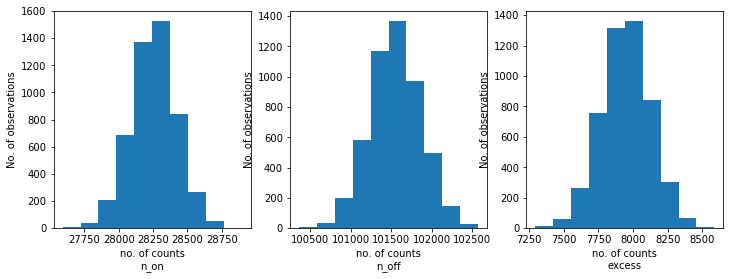

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 20min 46s, sys: 5.56 s, total: 20min 51s
Wall time: 21min 26s


In [15]:
results

[{'index': 2.08918040012255,
  'amplitude': 1.850177104819134e-12,
  'lambda_': 3.673352294360042},
 {'index': 2.246807419011836,
  'amplitude': 1.1098591702415119e-12,
  'lambda_': 2.7334017535608637},
 {'index': 2.106780651085318,
  'amplitude': 1.8190278475372278e-12,
  'lambda_': 3.589715644696545},
 {'index': 2.18563790614877,
  'amplitude': 1.4182434701104837e-12,
  'lambda_': 3.2199238719446983},
 {'index': 2.2335082148813235,
  'amplitude': 1.3108606151084685e-12,
  'lambda_': 3.0577825796166618},
 {'index': 2.2509457037855745,
  'amplitude': 1.1846104974806104e-12,
  'lambda_': 2.89042551828439},
 {'index': 2.3602379548752186,
  'amplitude': 8.955689341049595e-13,
  'lambda_': 2.5390207352432648},
 {'index': 2.0765373734656976,
  'amplitude': 1.9857797497104225e-12,
  'lambda_': 3.76726993622788},
 {'index': 2.2878256000698376,
  'amplitude': 1.0410776552645376e-12,
  'lambda_': 2.7678322508808515},
 {'index': 2.283895763951333,
  'amplitude': 1.0408090689897587e-12,
  'lambda

index: 2.2159803805548357 += 0.07875742243697191


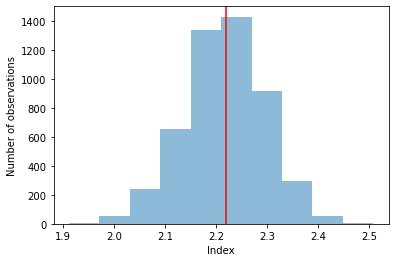

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.3396585297835178e-12 += 3.164857750961001e-13


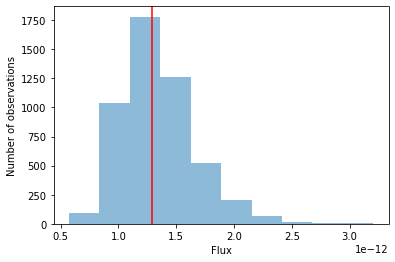

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 3.025662712199388 += 0.4052661235505641


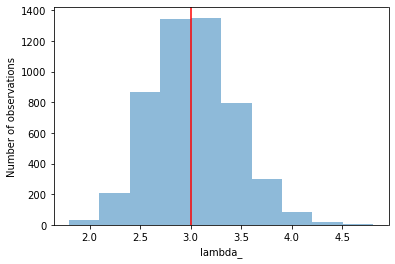

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")